In [232]:
import matplotlib.pyplot as plt
plt.rc('font',family='AppleGothic')
import numpy as np
import pandas as pd

In [233]:
data_raw = pd.read_csv('../used/data/raw_data/train.csv')
sample_submission_raw = pd.read_csv('../used/data/raw_data/sample_submission.csv')

data=data_raw.copy()
sample_submission=sample_submission_raw.copy()

In [234]:
data.set_index('일시',inplace=True)
data.index=pd.to_datetime(data.index,format='%Y%m%d')
data['week']=data.index.isocalendar().week
data['day_name']=data.index.weekday
data['weekend']=data['day_name'].apply(lambda x: 0 if x<5 else 1)
data['year']=data.index.year
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## 

sample_submission.set_index('일시',inplace=True)
sample_submission.index=pd.to_datetime(sample_submission.index,format='%Y%m%d')
sample_submission['week']=sample_submission.index.isocalendar().week
sample_submission['day_name']=sample_submission.index.weekday
sample_submission['weekend']=sample_submission['day_name'].apply(lambda x: 0 if x<5 else 1)
sample_submission['year']=sample_submission.index.year

In [235]:
from pytimekr import pytimekr
def get_holiday(_year):
    holidays=[]
    for holiday in pytimekr.holidays(year=_year):
        if pytimekr.red_days(holiday) != None:
            ans = [i.strftime("%Y-%m-%d") for i in pytimekr.red_days(holiday)]
            holidays.extend(ans)
        else:
            ans=holiday.strftime("%Y-%m-%d")
            holidays.append(ans)
    return list(set(holidays))

data.loc[get_holiday(2018),'weekend'] = 1
data.loc[get_holiday(2019),'weekend'] = 1
data.loc[get_holiday(2020),'weekend'] = 1
data.loc[get_holiday(2021),'weekend'] = 1
sample_submission.loc[sorted(get_holiday(2022))[:-1],'주말평일'] ='주말'

In [236]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [237]:
data_week_groupby=data.groupby(['year','week','weekend']).mean().reset_index()

In [238]:
df_2018=data_week_groupby[data_week_groupby['year']==2018].iloc[:,[1,2,3,4,5,6]]
df_2019=data_week_groupby[data_week_groupby['year']==2019].iloc[:,[1,2,3,4,5,6]]
df_2020=data_week_groupby[data_week_groupby['year']==2020].iloc[:,[1,2,3,4,5,6]]
df_2021=data_week_groupby[data_week_groupby['year']==2021].iloc[:,[1,2,3,4,5,6]]

In [239]:
year_df_list=[df_2018,df_2019,df_2020,df_2021]
for df in year_df_list:
    for col in df.iloc[:,2:].columns:
        df[col] = smooth(df[col],7)

In [240]:
from sklearn.preprocessing import MinMaxScaler
mms_2018 = MinMaxScaler()
mms_2019 = MinMaxScaler()
mms_2020 = MinMaxScaler()
mms_2021 = MinMaxScaler()

In [241]:
year_df_list=[df_2018,df_2019,df_2020,df_2021]
scaler_list=[mms_2018,mms_2019,mms_2020,mms_2021]
for df,mms in zip(year_df_list,scaler_list):
    df.iloc[:,2:] = mms.fit_transform(df.iloc[:,2:])

In [242]:
week_mean=pd.concat(year_df_list).groupby(['week','weekend']).mean().reset_index()

In [243]:
week_mean

,week,weekend,광진구,동대문구,성동구,중랑구
0,1,0,0.000000,0.000000,0.000000,0.000000
1,1,1,0.034379,0.036138,0.037351,0.027567
2,2,0,0.069503,0.071094,0.073133,0.059770
3,2,1,0.105487,0.109272,0.112585,0.090830
4,3,0,0.099792,0.101856,0.104050,0.088229
...,...,...,...,...,...,...
101,51,1,0.197307,0.235297,0.191927,0.212765
102,52,0,0.131153,0.158553,0.124878,0.148527
103,52,1,0.091892,0.118654,0.092212,0.110412
104,53,0,0.028854,0.074243,0.051411,0.062857


In [244]:
df_2018_weekmean=pd.DataFrame(mms_2018.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2018_weekmean['week'] = week_mean['week']
df_2018_weekmean['weekend'] = week_mean['weekend']
df_2019_weekmean=pd.DataFrame(mms_2019.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2019_weekmean['week'] = week_mean['week']
df_2019_weekmean['weekend'] = week_mean['weekend']
df_2020_weekmean=pd.DataFrame(mms_2020.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2020_weekmean['week'] = week_mean['week']
df_2020_weekmean['weekend'] = week_mean['weekend']
df_2021_weekmean=pd.DataFrame(mms_2021.inverse_transform(week_mean.iloc[:,2:]),columns=week_mean.iloc[:,2:].columns)
df_2021_weekmean['week'] = week_mean['week']
df_2021_weekmean['weekend'] = week_mean['weekend']

In [245]:
df_2021_weekmean.iloc[:,0]=df_2021_weekmean.iloc[:,0]+pd.concat([df_2018_weekmean.iloc[:,0],df_2019_weekmean.iloc[:,0],df_2020_weekmean.iloc[:,0],df_2021_weekmean.iloc[:,0]],axis=1).diff(axis=1).mean(axis=1)*3
df_2021_weekmean.iloc[:,1]=df_2021_weekmean.iloc[:,1]+pd.concat([df_2018_weekmean.iloc[:,1],df_2019_weekmean.iloc[:,1],df_2020_weekmean.iloc[:,1],df_2021_weekmean.iloc[:,1]],axis=1).diff(axis=1).mean(axis=1)*3
df_2021_weekmean.iloc[:,2]=df_2021_weekmean.iloc[:,2]+pd.concat([df_2018_weekmean.iloc[:,2],df_2019_weekmean.iloc[:,2],df_2020_weekmean.iloc[:,2],df_2021_weekmean.iloc[:,2]],axis=1).diff(axis=1).mean(axis=1)*3
df_2021_weekmean.iloc[:,3]=df_2021_weekmean.iloc[:,3]+pd.concat([df_2018_weekmean.iloc[:,3],df_2019_weekmean.iloc[:,3],df_2020_weekmean.iloc[:,3],df_2021_weekmean.iloc[:,3]],axis=1).diff(axis=1).mean(axis=1)*3

<AxesSubplot: >

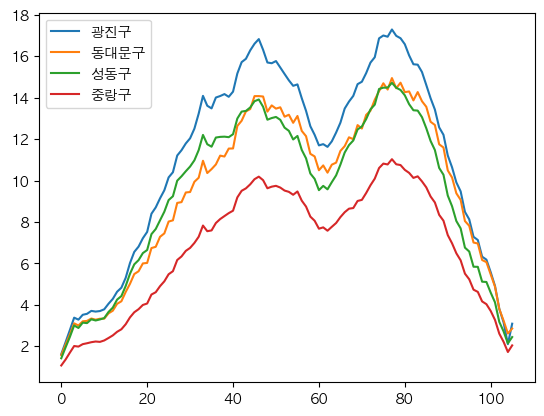

In [246]:
df_2021_weekmean.iloc[:,:4].plot()

In [247]:
sample_submission['week']=sample_submission['week'].apply(lambda x: 1 if x == 52 else x )

In [248]:
ans=sample_submission.merge(df_2021_weekmean,on=['week','weekend']).iloc[:,-4:]

In [251]:
sample_submission_raw.iloc[:,1:] = ans.values

In [253]:
sample_submission_raw.to_csv('final_ans.csv',index=False)